# NumPy: *Num*eric *Py*thon

(Pronounced "num-🥧", not "num-🫛")

The foundation of nearly all modern scientific computing in Python. This is NumPy + SciPy + Matplotlib, which form the core of the modern computing stack for [Scientific Python](https://scientific-python.org).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

It is used for N-dimensional arrays:

In [2]:
v = np.array([1, 2, 3])
v

array([1, 2, 3])

The clever trick is that computations on an array are pre-compiled, and can be much faster than Python:

In [3]:
v**2

array([1, 4, 9])

Note that it was designed for large arrays; around 10 elements or less you _might_ be faster using plain Python (though it's still more expressive). You should "vectorize" your code (by making the arrays bigger with more dimensions) if your arrays are very small and you care about performance.

This is what it would look like if we did it in loop based imparitive form (don't do this, it's much more verbose and slower, since it's running every step in the Python interpreter!)

In [4]:
y = np.empty_like(v)
for i in range(v.size):
    y[i] = v[i] ** 2
y

array([1, 4, 9])

Arrays can have multiple dimensions. You can put different types inside; since the "type" is a NumPy array, this is called "dtype", for "data type". For example, we can have a 2D array of 32-bit integers:

In [5]:
np.array([[1, 2, 3], [4, 5, 6]], dtype=np.int32)

array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

Unlike Python lists, which store Python objects of any type, NumPy arrays store a single type. This allows it to store data like a compiled language would, efficiently packed in memory.

NumPy also has lots of built in functions for manipulating and creating arrays. We'll use several of them below, but there are much more, check the [NumPy documentation](https://numpy.org/doc/stable/) for more!

## Slicing

NumPy slicing may not make copies of arrays, but can just adjust the start and strides of the data. This is usually true of reshaping and adding empty (length 1) dimensions, as well. For example:

In [8]:
arr = np.zeros([2, 3, 4], dtype=int)
print(arr.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



Slicing avoids a copy; we can see the effect of setting values, for example:

In [9]:
x = arr[:, :2, 2:]
x[...] = 1
print(arr)

[[[0 0 1 1]
  [0 0 1 1]
  [0 0 0 0]]

 [[0 0 1 1]
  [0 0 1 1]
  [0 0 0 0]]]


Flattening also avoids a copy if the data is contagious:

In [10]:
y = arr.ravel()
y[:3] = 2
print(arr)

[[[2 2 2 1]
  [0 0 1 1]
  [0 0 0 0]]

 [[0 0 1 1]
  [0 0 1 1]
  [0 0 0 0]]]


However, flattening / reshaping an array without a copy may not always be possible, such as if the data is non-contagious:

In [11]:
y = arr.T.ravel()
y[:3] = 3
print(arr)

[[[2 2 2 1]
  [0 0 1 1]
  [0 0 0 0]]

 [[0 0 1 1]
  [0 0 1 1]
  [0 0 0 0]]]


There is also support for "fancy indexing", which allows you to use a list of integers, which will pick out items, or a list/array of bools, which acts as a mask. These always make copies, since this can be (very) non contigious!

In [12]:
simple = np.arange(10,20)
simple

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [13]:
simple[simple%2==0]

array([10, 12, 14, 16, 18])

In [15]:
simple[[1,2,1,2]]

array([11, 12, 11, 12])

## Random Numbers

The simple random number interface `np.random.<distribution>` should only be used for highly interactive work. Normal usage should use a more modern, object oriented approach; first construct a random number generator:

In [16]:
rng = np.random.default_rng()

You can pass an explicit seed if you want reproducibility. Then this generator has distributions as methods:

In [17]:
dist = rng.normal(0, 1, size=1_000_000)

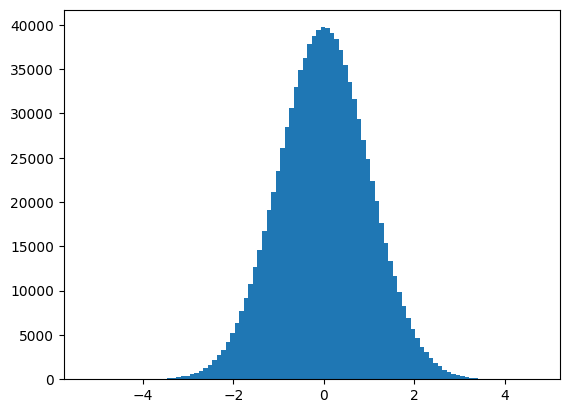

In [18]:
fix, ax = plt.subplots()
ax.hist(dist, bins=100)
plt.show()

The benefits include explicit control over the generator, reproducibility, and support for multiple independent generators.

## Broadcasting

One benefit of true 1D arrays (vs. languages that don't have 1D arrays) is that NumPy can support broadcasting. Broadcasting occurs whenever an operation (element-wise or matrix multiplication) encounters an array that is the wrong shape. The rules can be viewed two ways:

1. If the number of dimensions does not match, prepend length-1 dimensions until they do.
2. If the size of a dimension does not match and one of the dimensions is 1, duplicate along that axis to make it match.

Or:
1. Moving right to left, if a dimension is missing or 1, set the stride to 0 on that array, so the iteration pointer does not change along that dimension.

The former is often easier to reason about, while the later is how it's implemented (so it is very efficient).

In [20]:
(np.ones((2, 3, 4)) * np.ones((1, 4))).shape

(2, 3, 4)

You can predict the final shape with `broadcast_shapes`:

In [22]:
np.broadcast_shapes((2, 3, 4), (1, 4))

(2, 3, 4)

> Helpful rule: Broadcasting can seem confusing. To help clairify intent, try to avoid the automatic "prepend 1's" rule by explicitly matching the number of dimensions yourself. This greatly helps reasoning about each dimension.

You can also explicitly expand with `np.broadcast_arrays`.

Broadcasting is extremely useful for array-at-a-time programming, such as for coordinate arrays and the like. If you organize your calculations to delay expansion, you can optimize a lot of computation out.

For example, we can use `ogrid` or `meshgrid(..., sparse=True)` to replace `mgrid` but with compressed arrays ready for broadcasting. Here we make a grid with 101 points on x from 1-2 and 501 points on y from 0 to 5 (ends inclusive):

In [23]:
x, y = np.mgrid[2.5:3.5:101j, 0:5:501j]
radius = np.sqrt(x**2 + y**2)
print(f"{x.shape=}, {y.shape=}")
print(f"{radius[50,400] = }")

x.shape=(101, 501), y.shape=(101, 501)
radius[50,400] = np.float64(5.0)


In [24]:
x, y = np.ogrid[2.5:3.5:101j, 0:5:501j]
radius = np.sqrt(x**2 + y**2)
print(f"{x.shape=}, {y.shape=}")
print(f"{radius[50,400] = }")

x.shape=(101, 1), y.shape=(1, 501)
radius[50,400] = np.float64(5.0)


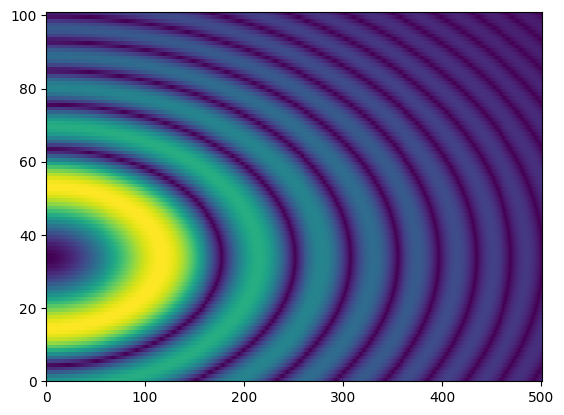

In [25]:
x, y = np.ogrid[-2:4:101j, 0:5:501j]
z = x + 1j*y
f = np.sin(np.abs(z**2)) * np.exp(-np.abs(z)/2)

plt.pcolormesh(np.abs(f))

## Masked arrays

A powerful and under supported feature is masked arrays. If values are missing, you can "mask" them.

This is quite nice logically, but the downside is not all interfaces support masked arrays. You also use extra space for the boolean mask. Another trick is to use NaN's in a floating point array, or to use Pandas's support for None's in all arrays.

In [26]:
x, y = np.mgrid[-5:5:101j, -5:5:101j]
radius = np.sqrt(x**2 + y**2)
mradius = np.ma.masked_where(radius > 5, radius)

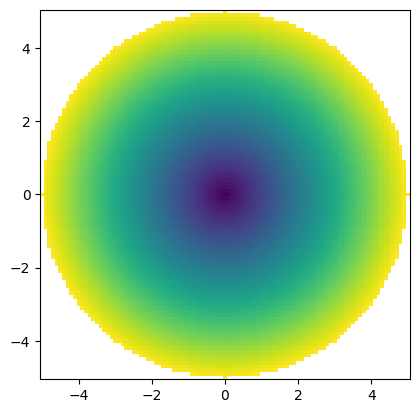

In [27]:
fix, ax = plt.subplots()
ax.pcolormesh(x, y, mradius)
ax.set_aspect("equal")
plt.show()

## Record arrays (AKA preview for Pandas!)

NumPy has support for complex DTypes. While Pandas or xarray handles structured dtypes more elegantly (and in a columnar form), but if you actually have data from some source that is structured and in an array form, this can be incredibly useful.

In [28]:
arr = np.array([(1, 2.0), (3, 4.0)], dtype=[("id", int), ("val", float)])
arr

array([(1, 2.), (3, 4.)], dtype=[('id', '<i8'), ('val', '<f8')])

You can select out a single named dtype (without copy) as well:

In [29]:
arr["val"]

array([2., 4.])

## Smaller features

### Buffer protocol

There's a buffer protocol in Python 3 that allows different libraries to communicate this sort of data without copies. This is also useful to communicate things like shared memory (for multiprocessing) or existing memory to NumPy.

In [ ]:
import array

In [ ]:
python_array = array.array("d", (1, 2, 3, 4))

We can explicitly convert from a buffer:

In [ ]:
np.frombuffer(python_array)

Or most NumPy functions also work directly on buffers by converting them:

In [ ]:
arr = np.asarray(python_array)

This "conversion" does not copy! You still are looking at the buffer's original memory:

In [ ]:
arr[1] = 42

In [ ]:
python_array

You can verify that the NumPy array doesn't own the memory:

In [ ]:
arr.flags.owndata

## Custom arrays

### UFuncs

NumPy has the concept of UFuncs; functions that can take array arguments (broadcastable) and will return a broadcast result. For example:

In [ ]:
np.sin(1)

In [ ]:
np.sin(np.array([0, 1, 2]))

In [ ]:
np.add(7, np.arange(3))

UFuncs have several standard keyword arguments:

* `out`: Output to existing array, skip allocation
* `where`: Mask computation
* `axes`, `axis`: axes to operate on (generalized UFuncs only)
* `keepdims`: To remove reduced dims (some generalized UFuncts only)
* `casting='same_kind'`: rules for casting different DTypes
* `order='K'`: memory layout ("K"eep)
* `dtype=None`: Dtype for output array
* `subok=True`: Output can be a subclass
* `signature`/`extobj`: Exact control over dtypes/buffers

(A generalized UFunc supports specific patterns, like matrix multiplication, rather than being element-wise)

UFuncs also support several methods and have a few properties. There are exactly six methods:

* `__call__`: Elementwise computation
* `at`: Local elementwise computation (provide indices)
* `reduce`: A reduction
* `reduceat`: A local reduction (provide indices)
* `accumulate`: An accumulation
* `outer`: An outer apply (`np.multiply.outer` is identical to `np.tensordot`)

### NEP 13/18

If you have a custom class, you can also customize UFuncs via NEP 13!

In [ ]:
import unittest

In [ ]:
class SimpleUnc(np.ndarray):
    pass


def simple_unc(val, unc):
    arr = np.array(list(zip(val, unc)), dtype=[("val", float), ("unc", float)])
    return arr.view(SimpleUnc)

In [ ]:
a = simple_unc([1, 2, 3], [0.1, 0.1, 0.1])
a

In [ ]:
a == a

We can see that this does raise an error if you try to add it, though:

In [ ]:
with unittest.TestCase().assertRaises(TypeError):
    a + a

Now let's provide `__array_ufunc__`, which will allow us to customize the behavior of UFuncs. This will use Python 3.10's pattern matching for simplicity.

In [ ]:
class SimpleUnc(np.ndarray):
    def __array_ufunc__(self, ufunc, method: str, *inputs, **kwargs):
        # Avoid infinite recursion
        raw_inputs = [np.asarray(x) for x in inputs]

        match (ufunc, method, raw_inputs):
            # Custom add / subtract
            case np.add | np.subtract, "__call__", (a, b):
                # This can waste an allocation
                (result,) = kwargs.pop("out", [np.empty(self.shape, self.dtype)])

                ufunc(a["val"], b["val"], out=result["val"], **kwargs)
                np.add(a["unc"] ** 2, b["unc"] ** 2, out=result["unc"], **kwargs)
                np.sqrt(result["unc"], out=result["unc"], **kwargs)

                return result.view(self.__class__)

            # Fall back on whatever it would have done before - do not return this subclass
            case _:
                return super().__array_ufunc__(ufunc, method, *raw_inputs, **kwargs)

In [ ]:
a = simple_unc([1, 2, 3], [0.1, 0.1, 0.1])
a + a

In [ ]:
a - a

This is very simple and doesn't account for correlations, but it does show that it works.

In [ ]:
a == a

There's a lot more to NumPy; it's worth looking around in the docs. An example of a function you might find is `np.diff(a)`, which is equivalent to `a[:-1] - a[1:]` but reads better without repeating the array name. Also look at the huge number of useful methods in SciPy.